### Linear Regression

This notebook applies linear OLS regression to predict the direction of market move‐ ments based on historical log returns. To keep things simple, only two features are used. The first feature (lag_1) represents the log returns of the financial time series lagged by one day. The second feature (lag_2) lags the log returns by two days. Log returns—in contrast to prices—are stationary in general, which often is a necessary condition for the application of statistical and ML algorithms.

The basic idea behind the usage of lagged log returns as features is that they might be informative in predicting future returns. For example, one might hypothesize that after two downward movements an upward movement is more likely (“mean reversion”), or, to the contrary, that another downward movement is more likely (“momentum” or “trend”). The application of regression techniques allows the formalization of such informal reasonings.

**The Data**

Load the data set:

In [8]:
import pandas as pd
raw = pd.read_csv('../Data/tr_eikon_eod_data.csv',
                              index_col=0, parse_dates=True).dropna()

Print the column names:

In [11]:
raw.columns

Index(['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'SPY', '.SPX', '.VIX',
       'EUR=', 'XAU=', 'GDX', 'GLD'],
      dtype='object')

Focus on EUR/USD exchange rate, prepare the data, compute the log returns, and compute the direction of the market (-1/1):

In [21]:
import numpy as np
symbol = 'EUR='
data = pd.DataFrame(raw[symbol])
data['returns'] = np.log(data / data.shift(1))
data.dropna(inplace=True)
data['direction'] = np.sign(data['returns']).astype(int)
data.head()

,EUR=,returns,direction
Date,,,
2010-01-05,1.4368,-0.002988,-1
2010-01-06,1.4412,0.003058,1
2010-01-07,1.4318,-0.006544,-1
2010-01-08,1.4412,0.006544,1
2010-01-11,1.4513,0.006984,1


Plot the histogram of the returns:

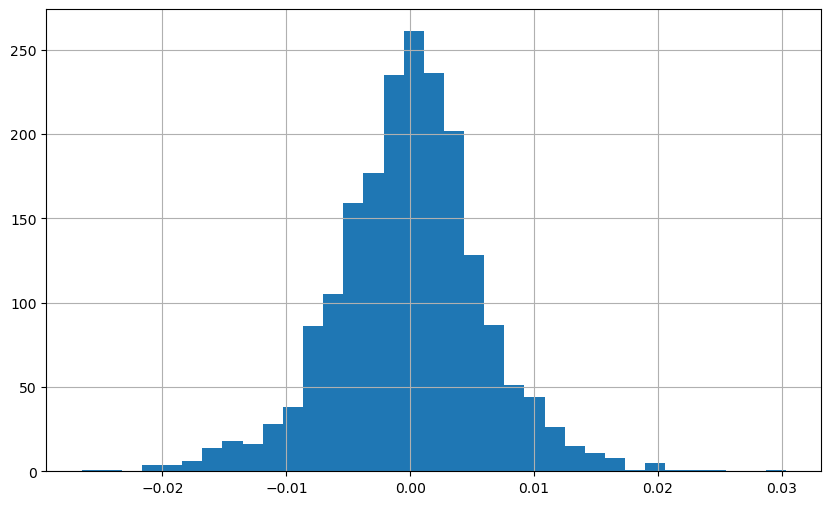

In [24]:
data['returns'].hist(bins=35, figsize=(10, 6));

Creates the features data by lagging the log returns and visualizes it in combination with the returns data:

In [27]:
lags = 2
def create_lags(data):
    global cols
    cols = []
    for lag in range(1, lags + 1):
                     col = 'lag_{}'.format(lag)
                     data[col] = data['returns'].shift(lag)
                     cols.append(col)

In [29]:
create_lags(data)

In [31]:
data.head()

,EUR=,returns,direction,lag_1,lag_2
Date,,,,,
2010-01-05,1.4368,-0.002988,-1,NaN,NaN
2010-01-06,1.4412,0.003058,1,-0.002988,NaN
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544


In [33]:
data.dropna(inplace=True)

Create a scatter plot of the data:

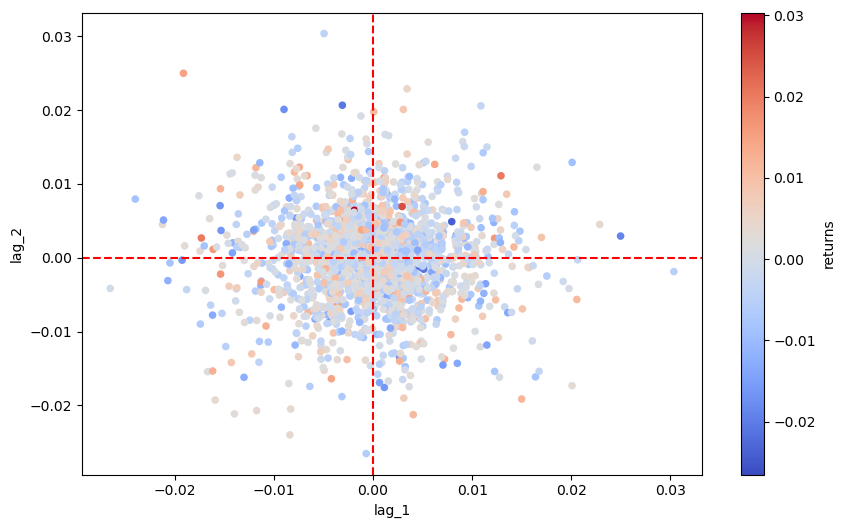

In [40]:
import matplotlib.pyplot as plt
data.plot.scatter(x='lag_1', y='lag_2', c='returns',
                           cmap='coolwarm', figsize=(10, 6), colorbar=True) 
plt.axvline(0, c='r', ls='--')
plt.axhline(0, c='r', ls='--');

### Regression

With the data set completed, linear OLS regression can be applied to learn about any potential (linear) relationships, to predict market movement based on the features, and to backtest a trading strategy based on the predictions. Two basic approaches are available: using the log returns or only the direction data as the dependent variable during the regression. In any case, predictions are real-valued and therefore transformed to either +1 or -1 to only work with the direction of the prediction:

Import the equired library and call linear regression model:

In [45]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

Implement reg. model using log returns as independent variable:

In [48]:
data['pos_ols_1'] = model.fit(data[cols],data['returns']).predict(data[cols])

Implement reg. model using direction as independent variable:

In [51]:
data['pos_ols_2'] = model.fit(data[cols],data['direction']).predict(data[cols])

Take a peak at the modified data:

In [54]:
data[['pos_ols_1', 'pos_ols_2']].head()

,pos_ols_1,pos_ols_2
Date,,
2010-01-07,-0.000202,-0.004063
2010-01-08,0.000046,0.043384
2010-01-11,-0.000310,-0.019115
2010-01-12,-0.000143,-0.042655
2010-01-13,0.000007,0.005976


Transformed the predicted values to directional values (+1, -1):

In [62]:
data[['pos_ols_1', 'pos_ols_2']] = np.where(data[['pos_ols_1', 'pos_ols_2']] > 0, 1, -1)

Count the directions in the two regression models:

In [65]:
data['pos_ols_1'].value_counts()

pos_ols_1
-1    1605
 1     364
Name: count, dtype: int64

In [67]:
data['pos_ols_2'].value_counts()

pos_ols_2
 1    1231
-1     738
Name: count, dtype: int64

The two approaches yield different directional predictions in general. However, both lead to a relatively large number of trades over time:

In [71]:
(data['pos_ols_1'].diff() != 0).sum()

701

In [73]:
(data['pos_ols_2'].diff() != 0).sum()

789

Equipped with the directional prediction, vectorized backtesting can be applied to judge the performance of the resulting trading strategies. At this stage, the analysis is based on a number of simplifying assumptions, such as “zero transaction costs” and the usage of the same data set for both training and testing. Under these assumptions, however, both regression-based strategies outperform the benchmark passive investment:

In [76]:
data['strat_ols_1'] = data['pos_ols_1'] * data['returns']
data['strat_ols_2'] = data['pos_ols_2'] * data['returns']

In [78]:
 data[['returns', 'strat_ols_1', 'strat_ols_2']].sum().apply(np.exp)

returns        0.807938
strat_ols_1    1.345052
strat_ols_2    1.418594
dtype: float64

Both of the OLS regression strategy showed a positive overall performance:

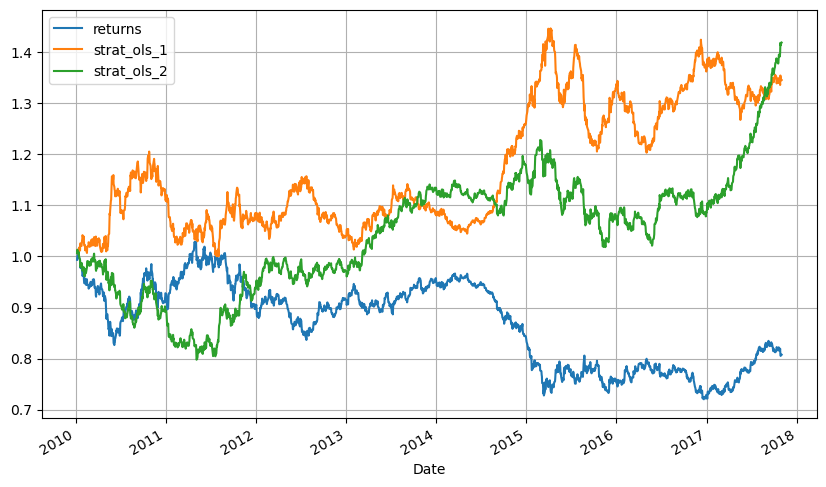

In [85]:
data[['returns', 'strat_ols_1', 'strat_ols_2']].cumsum().apply(np.exp).plot(figsize=(10, 6), grid=True);